# Лабораторная работа 3. Линейные методы.

Результат лабораторной работы − отчет. Мы принимаем отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

### Оценивание и штрафы
* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за работу — 10 баллов
* Сдавать задание после указанного срока сдачи нельзя
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировкам

Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.

##### Вострецов Павел, ШАД

<a id='log_reg'></a>
## Логистическая регрессия

В этом пункте мы будем рассматривать бинарную классификацию, где метки классов лежат во множестве $\{-1, 1\}$. 

Задачу обучения регуляризованной логистической регрессии можно записать следующим образом:

$$ \dfrac{1}{N}\sum_{i=1}^N \log(1 + \exp(-\langle w, x_i \rangle y_i)) + \dfrac{C}{2}\lVert w \rVert^2  \to \min_w$$

Обучение в данном случае сводится к нахождению параметров модели $w$, которое производится с помощью метода градиентного спуска (Gradient Descent, GD). 

Градиентный шаг будет заключаться в обновлении вектора весов по следующей формуле:

$$w := w + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w, x_i \rangle y_i)}\Big) - \eta Cw$$

где $\eta > 0$ — размер шага (learning rate).

В общем случае метод градиентного спуска имеет следующие недостатки:
- попадание в локальные минимумы
- неочевидность критерия останова
- выбор размера шага
- начальная инициализация весов

В этой части лабораторной работы мы предложим вам реализовать метод градиентного спуска, а также рассмотрим некоторые его модификации.



In [46]:
import numpy as np
import numpy.linalg
import pandas as pd
import pylab as plt
import scipy.linalg as sla

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification, make_regression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score

%matplotlib inline

### Задание

Сгенерируйте выборку из 1000 точек с 20 признаками на которой будете проводить эксперименты. Мы рекомендуем воспользоваться функцией [make_classification](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification) из пакета sklearn. Обратите внимание, что метки классов для данной задачи должны быть из множества {-1, 1} (по умолчанию make_classification возвращает метки из множества {0, 1}).

In [47]:
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X = pd.DataFrame(X, columns=list(map(lambda i: f'v{i}', range(20))))
y = pd.DataFrame(y*2 - 1, columns=['label']).label

In [48]:
X.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19
0,-0.669356,-1.495778,-0.870766,1.141831,0.021606,1.730630,-1.251698,0.289305,0.357163,-0.196811,0.829274,0.154850,-0.219970,-0.739137,1.802012,1.634606,-0.938180,-1.267337,-1.276334,1.016643
1,0.093372,0.785848,0.105754,1.272354,-0.846316,-0.979093,1.263707,0.264020,2.411677,-0.960046,0.543479,0.199810,0.288724,0.732492,-0.872002,-1.654887,-1.130204,-0.122709,0.693431,0.911363
2,-0.905797,-0.608341,0.295141,0.943716,0.092936,1.370397,-0.064772,0.287273,-0.533004,-0.032504,-0.549925,-0.510064,-0.868768,-0.598279,0.019832,0.613460,-1.779439,0.830498,-0.737332,-0.578212
3,-0.585793,0.389279,0.698816,0.436236,-0.315082,0.459505,1.448820,0.505558,-1.440982,-1.134020,-0.241431,1.466783,0.678728,-1.190917,-1.442381,-0.929136,-0.221600,-0.346772,0.034246,-1.040199
4,1.146441,0.515579,-1.222895,-0.396230,-1.293508,-0.352428,0.071254,1.239584,1.007133,-1.479444,-0.695695,-0.918127,0.604121,1.068379,-0.882271,2.303639,-0.973379,1.259233,0.360015,1.920368


In [49]:
y.head()

0    1
1   -1
2    1
3    1
4   -1
Name: label, dtype: int32

**(2.5 балла)** Реализуйте градиентный спуск и протестируйте его для случая логистической регрессии на ранее сгенерированной выборке. Для сравнения качества разных подходов используйте значение оптимизируемого функционала.

В качестве критерия останова мы предлагаем использовать следующие условия:
 - евклидова норма разности текущего и нового векторов весов стала меньше, чем 1e-4
 - ограничение на число итераций (например, 10000)
 
Для начальной инициализации весов нужно сравнить следующие подходы:
 - нулевая начальная инициализация
 - случайная
 
Выполните следующие пункты и прокомментируйте полученные результаты:
- Рассмотрите как влияет размер шага на сходимость (попробуйте не менее 5-ти различных значений).
- Рассмотрите регуляризованную модель, которая описана выше, а также модель без регуляризатора. Сравните влияет ли наличие регуляризации на скорость сходимости и качество.
- Исследуйте качества оптимизируемого функционала в зависимости от номера итерации (при правильной реализации и подходящем размере шага он должен убывать).
- Влияет ли выбор начальной инициализации весов на скорость и качество?

В каждом пункте требуется построить необходимые графики скорости/качества и дать исчерпывающие выводы.

In [50]:
def gradient_descent_step(X, y, C, eta, w):
    assert len(X.shape) == 2
    n, m = X.shape
    assert n == y.shape[0]
    assert m == w.shape[0]

    sum_ = np.sum(y*X.T*(1 - 1/(1 + np.power(np.e, -y*np.sum(w*X, axis=1)))), axis=1)
    return w + eta/len(X)*sum_ - eta*C*w

def functional(X, y, C, w):
    sum_ = np.sum(np.log(1 + np.power(np.e, -y*np.sum(w*X, axis=1))))
    return 1/len(X)*sum_ + C/2*numpy.linalg.norm(w)**2

def gradient_descent(X, y, C, eta, w):
    functionals = [functional(X, y, C, w)]
    for _ in range(10000):
        w_old = w
        w = gradient_descent_step(X, y, C, eta, w)
        functionals.append(functional(X, y, C, w))
        if numpy.linalg.norm(w_old - w) < 1e-4:
            break
    return w, functionals

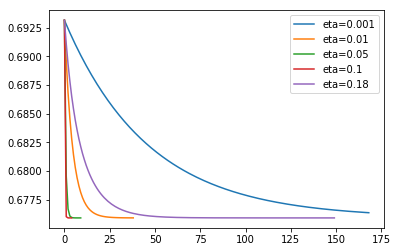

In [51]:
for eta in [0.001, 0.01, 0.05, 0.1, 0.18]:
    w, functionals = gradient_descent(X, y, 10, eta, np.zeros((20,)))
    plt.plot(functionals, label=f'eta={eta}')
plt.legend()

Видно, что шаг влияет на скорость уменьшения функционала ошибки. При этом больший шаг не всегда означает более быструю сходимость (видно на примере `eta=0.18`, скорее всего, при таком шаге слишком большая $\Delta w$, из-за чего алгоритм долго сходится). С другой стороны, если взять слишком малое значение `eta=0.001`, сходимость тоже будет довольно медленной, потому что алгоритм слишком медленно спускается до оптимального значения при таком маленьком шаге. На графиках видно, что в данном случае оптимальным является значение `eta=0.1`.

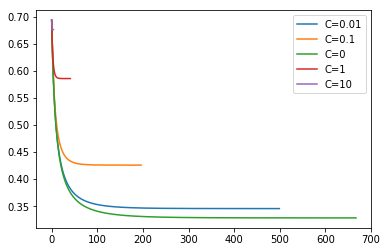

In [52]:
for C in [0.01, 0.1, 0, 1, 10]:
    w, functionals = gradient_descent(X, y, C, 0.1, np.zeros((20,)))
    plt.plot(functionals, label=f'C={C}')
plt.legend()

Видно, что регуляризация влияет как на скорость сходимости, так и на качество. Понятно, что при отсутствии регуляризации (или при слабой регуляризации) качество будет лучше, чем при больших коэффициентах регуляризации. Так происходит из-за того, что отсутствие коэффициента регуляризации позволяет нам точнее подогнать веса (при этом возможно переобучение).

Также на графиках видно, что регуляризация влияет и на скорость сходимости. При большем коэффициенте регуляризации скорость сходимости оказалась выше.

На обоих вышеприведенных графиках видно, что с увеличением номера итерации оптимизируемый функционал убывает.

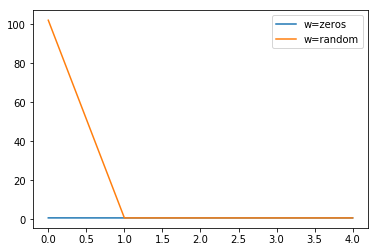

In [53]:
for i, w_start in enumerate([np.zeros((20,)), np.random.randn(20)]):
    w, functionals = gradient_descent(X, y, 10, 0.1, w_start)
    plt.plot(functionals, label=f'w={"zeros" if i == 0 else "random"}')
plt.legend()

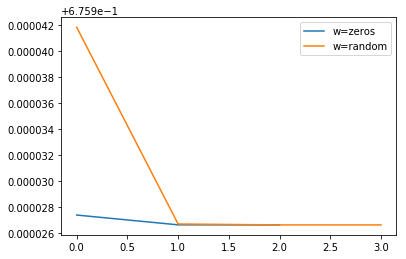

In [54]:
for i, w_start in enumerate([np.zeros((20,)), np.random.randn(20)]):
    w, functionals = gradient_descent(X, y, 10, 0.1, w_start)
    plt.plot(functionals[2:], label=f'w={"zeros" if i == 0 else "random"}')
plt.legend()

В данном случае инициализация весов повлияла на скорость, но не повлияла на качество. Видно, что при случайной инициализации мы получили неудачную точку, но потом быстро спустились к оптимальному значению. В итоге при инициализации нулями алгоритм отработал за 4 итерации, а при инициализации случайными значениями - за 5 итераций.

Метод градиентного спуска может быть весьма трудозатратен в случае большого размера обучающей выборки. Поэтому обычно используют метод стохастического градиентного спуска, где на каждой итерации выбирается случайный объект из обучающей выборки и обновление весов происходит сразу по этому объекту. 

**(1.5 балла)** Реализуйте метод стохастического градиентного спуска (sgd). В этом случае вы можете выбрать наиболее удачный функционал, исходя из предыдущего пункта (с регуляризацией, без), а также схему начальной инициализации весов. Реализуйте метод в виде класса, удовлетворяющего интерфейсу scikit-learn ([тут есть пример](http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/)).

Сравните рассмотренные методы (градиентный спуск и sgd) между собой с точки зрения скорости сходимости и качества.

- Посмотрите как влияет размер шага на сходимость (попробуйте 4-5 различных значений)
- Исследуйте качество оптимизируемого функционала в зависимости от номера итерации

Выберите лучший размер шага и сравните качество и скорость сходимости реализованного метода и [его аналога из scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) (не забудьте выставить значения важных параметров tol и learning_rate для сравнения методов в приближённо равных условиях). Насколько получилось лучше/хуже, в чём могут быть причины?

В каждом пункте сделайте исчерпывающие выводы, подкреплённые графиками.

In [55]:
class StochasticGradientDescentClassifier(BaseEstimator, ClassifierMixin):  
    def __init__(self, w_init=None, eta=1e-3, C=1, max_iter=1e4,
                 min_weight_dist=1e-8, random_state=42):
        self.eta = eta
        self.C = C
        self.max_iter = max_iter
        self.min_weight_dist = min_weight_dist
        self.random_state = random_state
        self.w_init = w_init
        self.weights_ = None
        self.errors_ = None

    def _stochastic_gradient_step(self, X, y, w, train_ind):
        assert len(X.shape) == 2
        n, m = X.shape
        assert n == y.shape[0]
        assert m == w.shape[0]
        
        n = len(X)
        X = X.iloc[train_ind]
        y = y.iloc[train_ind]
        sum_ = y*X*(1 - 1/(1 + np.power(np.e, -y*np.sum(w*X))))
        return w + self.eta/n*sum_ - self.eta*self.C*w

    def _functional(X, y, C, w):
        sum_ = np.sum(np.log(1 + np.power(np.e, -y*np.sum(w*X, axis=1))))
        return 1/len(X)*sum_ + C/2*numpy.linalg.norm(w)**2
        
    def _stochastic_gradient_descent(self, X, y):
        weight_dist = np.inf
        w = self.w_init
        if w is None:
            w = np.zeros(X.shape[1])
        functionals = []
        iter_num = 0
        np.random.seed(self.random_state)
        while weight_dist > self.min_weight_dist and iter_num < self.max_iter:
            random_ind = np.random.randint(X.shape[0])
            w_ = w
            w = self._stochastic_gradient_step(X, y, w_, random_ind)
            functionals.append(functional(X, y, self.C, w))
            weight_dist = np.linalg.norm(w - w_)
            iter_num += 1
        return w, functionals
    
    def fit(self, X, y=None):
        self.weights_, self.functionals_ = self._stochastic_gradient_descent(X, y)
        return self
    
    def predict(self, X, y=None):
        return np.sum(X*w, axis=1)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = StochasticGradientDescentClassifier(min_weight_dist=1e-6)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean_squared_error(y_pred, y_test)

0.8770519766509558

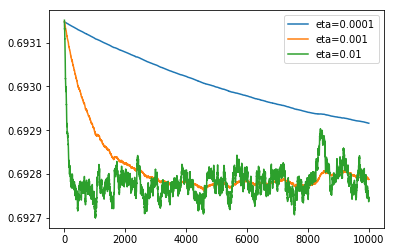

In [57]:
for eta in [0.0001, 0.001, 0.01]:
    clf = StochasticGradientDescentClassifier(min_weight_dist=eta/1000, eta=eta)
    clf.fit(X, y)
    plt.plot(clf.functionals_, label=f'eta={eta}')
plt.legend()

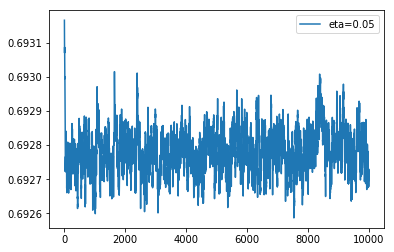

In [58]:
clf = StochasticGradientDescentClassifier(min_weight_dist=1e-8, eta=0.05)
clf.fit(X, y)
plt.plot(clf.functionals_, label=f'eta=0.05')
plt.legend()

По графикам видно, что при больших значениях шага алгоритм кидает из стороны в сторону. При этом у меня не получилось оптимально подобрать `min_weight_dist`, так как у меня алгоритм отрабатывает либо `max_iter` количество раз, что долго, либо отрабатывает 1 раз и заканчивает работу.

По графикам видно, что наиболее оптимальным является значение `eta=0.001`.

Видно, что при меньших шагах оптимизируемый функционал убывает с ростом номера итерации. При этом, при больших шагах функционал начинает сильно колебаться.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = StochasticGradientDescentClassifier(min_weight_dist=1e-8, eta=0.001, C=0.0001)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean_squared_error(y_pred, y_test)

0.8770519766509558

In [60]:
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, 
                    max_iter=1e4, tol=1e-8, verbose=0, n_jobs=1,
                    random_state=42, learning_rate='constant', eta0=0.001)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean_squared_error(y_pred, y_test)

0.59393939393939399

In [61]:
clf.n_iter_

17

Видно, что классификатор из sklearn оказался намного быстрее и получил лучшее качество. Он оказался быстрее, потому что он завершился за 17 итераций, когда как мой алгоритм отработал 10000 итераций. Также он быстрее, потому что скорее всего большая часть алгоритма реализована на C/C++.

Также ошибка встроенного классификатора получилась намного меньше, чем ошибка моего классификатора. Возможно, это произошло из-за того, что коэффициенты у встроенного алгоритма не соответствуют коэффициентам в реализованном вручную алгоритме.

**(0.5 балла)** Добавьте в выборку случайный шум следующим способом:
 1. Выберите случайно 3% объектов из сгенерированной ранее выборки.
 2. Сдвиньте эти объекты на $\mathcal{N}(0; 3 * scale)$, где $scale$ —  масштаб, который был использован при генерации объектов (параметр $scale$ в make_classification).
 3. Инвертируйте классы выбранных объектов.
 
Для GD и SGD сравните скорость сходимости и значение функции потерь до и после добавления шума. Сделайте необходимые выводы, подкреплённые графиками.

In [62]:
np.random.seed(42)
X_noise = X.copy()
y_noise = y.copy()
for i in range(30):
    ind = np.random.randint(X.shape[0])
    X_noise.iloc[ind] = X.iloc[ind] + numpy.random.normal(loc=0.0, scale=3.0, size=X.shape[1])
    y_noise[ind] = -y[ind]

Gradient Descent


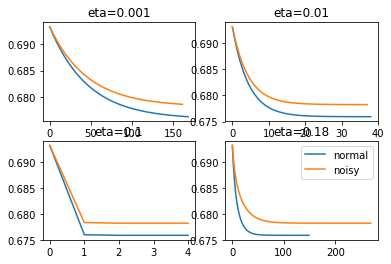

In [63]:
fig = plt.figure()
sub = [221, 222, 223, 224]
etas = [0.001, 0.01, 0.1, 0.18]
for sub, eta in zip(sub, etas):
    ax = fig.add_subplot(sub)
    w, functionals = gradient_descent(X, y, 10, eta, np.zeros((20,)))
    w_n, functionals_n = gradient_descent(X_noise, y_noise, 10, eta, np.zeros((20,)))
    ax.plot(functionals, label=f'normal')
    ax.plot(functionals_n, label=f'noisy')
    ax.set_title(f'eta={eta}')
plt.legend()
print('Gradient Descent')

Stochastic Gradient Descent


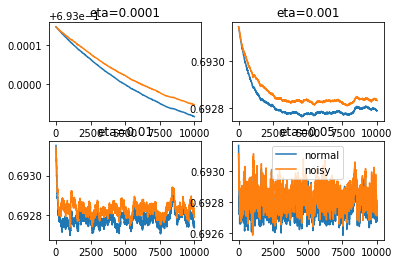

In [64]:
fig = plt.figure()
sub = [221, 222, 223, 224]
etas = [0.0001, 0.001, 0.01, 0.05]
for sub, eta in zip(sub, etas):
    ax = fig.add_subplot(sub)
    clf = StochasticGradientDescentClassifier(min_weight_dist=1e-8, eta=eta)
    clf.fit(X, y)
    ax.plot(clf.functionals_, label='normal')
    clf = StochasticGradientDescentClassifier(min_weight_dist=1e-8, eta=eta)
    clf.fit(X_noise, y_noise)
    ax.plot(clf.functionals_, label='noisy')
    ax.set_title(f'eta={eta}')
plt.legend()
print('Stochastic Gradient Descent')

Как для стохастического, так и для обычного градиентного спуска, значения функции потерь после добавления шума увеличилось. Какой-то определенный вывод про скорость сходимости сделать не удается. Видно, что у обычного градиентного спуска при добавлении шума скорость сходимости даже немного выросла (на трех графиках), а при `eta=0.18` скорость сходимости упала почти в 2 раза. Стохастический градиентный спуск у меня не сходится и отрабатывает `max_iter` итераций.

Между обновлением вектора весов по всей выборке и на одном объекте есть промежуточный подход — выбирать некоторое случайное подмножество объектов и обновлять веса по нему. Такой подход называется mini-batch. Мы не будем реализовывать этот подход в данной работе, однако иногда его бывает осмысленно использовать на практике. 

Один из недостатков sgd состоит в том, что он может не доходить до локального оптимального решения, а осциллировать в окрестности. 

![](http://sebastianruder.com/content/images/2015/12/without_momentum.gif)

Для решения этой проблемы существуют методы, позволяющие устранить этот недостаток, а также ускорить сходимость. Рассмотрим некоторые из них.

![](http://nghenglim.github.io/images/2015061300.png)

### Momentum

Этот метод позволяет направить sgd в нужной размерности и уменьшить осцилляцию. 

В общем случае он будет выглядеть следующим образом: 

$$ v_t = \gamma v_{t - 1} + \eta \nabla_{\theta}{J(\theta)}$$
$$ \theta = \theta - v_t$$

где

 - $\theta$ — вектор параметров (в нашем случае — $w$)
 - $J$ — оптимизируемый функционал
 - $\gamma$ — momentum term (обычно выбирается 0.9)
 
### Adagrad 

Одной из сложностей является выбор размера шага (*learning rate*). Основное отличие данного метода от SGD состоит в том что размер шага определяется для каждого параметра индивидуально. Этот метод хорошо работает с разреженным данным большого объема. 

Обозначим градиент по параметру $\theta_i$ на итерации $t$ как $g_{t,i} = \nabla_{\theta}J(\theta_i)$. 

В случае sgd обновление параметра $\theta_i$ будет выглядеть следующим образом:

$$ \theta_{t+1, i} = \theta_{t, i} - \eta \cdot g_{t,i}$$

А в случае Adagrad общий шаг $\eta$ нормируется на посчитанные ранее градиенты для данного параметра:

$$ \theta_{t+1, i} = \theta_{t, i} - \dfrac{\eta}{\sqrt{G_{t,ii} + \varepsilon}} \cdot g_{t,i}$$

где $G_t$ — диагональная матрица, где каждый диагональный элемент $i,i$ — сумма квадратов градиентов для $\theta_{i}$ до $t$-ой итерации. $\varepsilon$ — гиперпараметр, позволяющий избежать деления на 0 (обычно выбирается около *1e-8*).

Так как матрица $G_t$ диагональна, в векторном виде это будет выглядеть следующим образом (здесь $\odot$ — матричное умножение):

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{G_t + \varepsilon}} \odot g_t $$

### Adadelta

Adadelta, в отличии от Adagrad, рассматривает не все предыдущие значения градиентов, а только последние $k$. Кроме того, сумма градиентов определяется как уменьшающееся среднеее всех предыдущих квадратов градиентов. Текущее среднее $E[g^2]_t$ на итерации $t$ будет вглядеть следующим образом:

$$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma)g_t^2 $$

здесь $\gamma$ аналогична гиперпараметру из метода Momentum.

Тогда обновление весов можно записать следующим образом:

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Перепишем это немного по-другому:

$$ \theta_{t+1} = \theta_{t} + \Delta \theta_t$$ 
$$\Delta \theta_t = - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Аналогично среднему для градиентов определим среднее для параметров $\theta$:

$$ E[\Delta \theta^2]_t = \gamma E[\Delta \theta^2]_{t-1} + (1-\gamma)\Delta \theta^2 $$

Введем обозначение $RMS[p]_t = \sqrt{E[p]_t + \varepsilon}$

Тогда Adadelta выглядит следующим образом:

$$\Delta \theta_t = - \dfrac{RMS[\Delta \theta^2]}{RMS[ga^2]} g_t $$ 
$$ \theta_{t+1} = \theta_{t} + \Delta \theta_t$$ 


Более подробно об этих и других способах оптимизации можно прочитать:
 - [здесь](http://sebastianruder.com/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms) очень хорошее описание различных способов оптимизации, в этом задании мы опираемся на терминологию из данной статьи
 - статья про [momentum](https://pdfs.semanticscholar.org/97da/c94ffd7a7ac09a4218848300cc7e98569d77.pdf)
 - оригинальная статья про [adagrad](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
 - оригинальная статья про [adadelta](http://arxiv.org/pdf/1212.5701v1.pdf)
 - википедия про [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) и [adagrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad)
 - [визуализация](http://imgur.com/a/Hqolp) разных способов оптимизации

### Задание

Реализуйте любые два метода из предложенных трех **(1 балл)**.
- Сравните оба метода с классическим sgd с точки зрения скорости сходимости.
- Посмотрите как значение гиперпараметра $\gamma$ влияет на скорость сходимости и качество в методе *Momentum*.

В заданиях выше требуется построить графики и описать полученные результаты.

Дало ли преимущество использование адаптивного шага в методе *Adagrad*/*Adadelta*?

## Линейная регрессия

![](http://66.147.244.197/~globerov/introspectivemode/wp-content/uploads/2012/08/regression-265x300.jpeg)

Метод градиентного спуска позволяет оптимизировать произвольные функции. Например, рассмотрим задачу линейной регрессии, где $y \in \mathbb{R}$, а алгоритм будет иметь вид $a(x) = \langle w, x\rangle$. В случае метода наименьших квадратов оптимизируемый функционал можно записать следующим образом:

$$ \sum_{i=1}^N (\langle w, x_i \rangle - y_i) ^ 2 \to \min_w$$

Эта задача интересна тем, что для нее можно выписать аналитическое решение. Попробуем сравнить эти подходы.

### Задание

Сгенерируйте выборку из 600 точек с двумя признаками для задачи регрессии, воспользовавшись функцией [make_regression](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html#sklearn.datasets.make_regression). 

In [65]:
X, y = make_regression(n_samples=600, n_features=2, random_state=42)
X = pd.DataFrame(X, columns=['v1', 'v2'])
y = pd.DataFrame(y, columns=['label']).label

**(0.5 балла)** Выпишите как выглядит точное решение задачи линейной регрессии. Решите задачу регрессии с помощью этого подхода без использования и с использованием регуляризации. Есть ли недостатки у такого подхода к решению задачи?

**(0.5 балла)** Примените метод стохастического градиентного спуска реализованный ранее. Сильно ли отличается полученный вектор параметров по сравнению с точным решением? 

К сожалению, линейная регрессия позволяет хорошо восстанавливать *линейные* зависимости, однако в общем случае хуже работает с более сложными данными. Это хорошо можно увидеть на следующем примере.

Пусть исходная зависимость имеет вид $y = x \cdot sin(x)$. Сгенерируем соответствующие точки:

In [66]:
from sklearn.cross_validation import train_test_split

C:\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [67]:
X = np.linspace(0, 10, 100)
y = X * np.sin(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

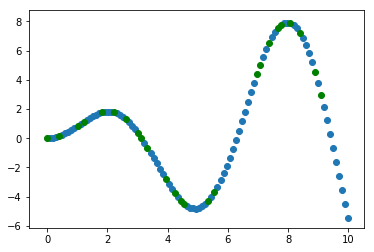

In [68]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')

Если теперь к полученным данным применить модель линейной регрессии, то получим следующее решение:

In [69]:
from sklearn.linear_model import LinearRegression

In [70]:
lr = LinearRegression()
lr.fit(X_train[:, np.newaxis], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

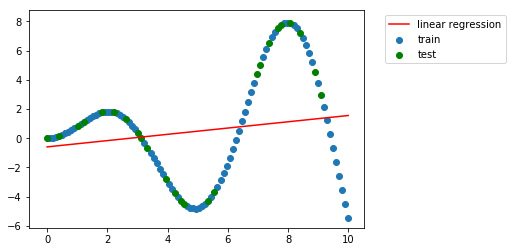

In [71]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')
y_plot = lr.predict(X[:, np.newaxis])
_ = plt.plot(X, y_plot, c='r')
_ = plt.legend(('linear regression', 'train', 'test'), bbox_to_anchor=(1.05, 1), loc=2)

Качество модели регрессии можно оценивать с помощью некоторых метрик, например $MSE = \sum_{i=1}^l(a(x_i) - y_i)^2$ и в данном случае оно равно:

In [72]:
from sklearn.metrics import mean_squared_error

In [73]:
mean_squared_error(y_test, lr.predict(X_test[:, np.newaxis])) 

14.759977502823233

Построенное решение совсем отдаленно напоминает исходную зависимость. Одним из способов улучшить результат является добавление всех попарных произведений признаков, а также степеней: $x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2, \dots$

### Задание

**(0.5 балла)** Воспользуйтесь классом [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) и добавьте к данным зависимости $y = x \cdot sin(x)$ различные полиномы.

 - рассмотрите как степень полинома (от 1 до 20) влияет на качество
 - изобразите на графике предсказание аналогично линейной регрессии
 - сравните этот подход с функцией [polyfit](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.polyfit.html)

В чем могут быть недостатки такого подхода?

In [74]:
X_df = pd.DataFrame(X.reshape(-1, 1), columns=['x'])
X_df.head()

,x
0,0.00000
1,0.10101
2,0.20202
3,0.30303
4,0.40404


In [75]:
def get_poly(X, degree):
    poly = PolynomialFeatures(degree=degree)
    columns = ['1', 'x'] + list(map(lambda i: f'x**{i}', range(2, degree + 1)))
    return pd.DataFrame(poly.fit_transform(X), columns=columns)

def plot_poly(i):
    X_poly = get_poly(X_df, i)
    X_poly_train, X_poly_test, y_train, y_test = train_test_split(X_poly, y, random_state=42)
    lr = LinearRegression()
    lr.fit(X_poly_train, y_poly_train)
    _ = plt.scatter(X_train, y_train)
    _ = plt.scatter(X_test, y_test, c='g')
    y_plot = lr.predict(X_poly)
    _ = plt.plot(X, y_plot, c='r')
    _ = plt.legend(('linear regression', 'train', 'test'), bbox_to_anchor=(1.05, 1), loc=2)

In [76]:
errs = []
for i in range(1, 30):
    X_poly = get_poly(X_df, i)
    X_poly_train, X_poly_test, y_train, y_test = train_test_split(X_poly, y, random_state=42)
    lr = LinearRegression()
    lr.fit(X_poly_train, y_poly_train)
    errs.append(mean_squared_error(y_poly_test, lr.predict(X_poly_test)))
plt.xlabel('degree')
plt.ylabel('mse')
plt.plot(errs)

NameError: name 'y_poly_train' is not defined

Видно, что чем выше степень полинома, тем выше качество, однако, если взять степень выше 20, то по графику видно, что начинается переобучение.

In [ ]:
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, random_state=42)
lr = LinearRegression()
lr.fit(X_poly_train, y_poly_train)
mean_squared_error(y_poly_test, lr.predict(X_poly_test))

In [ ]:
plot_poly(2)

In [ ]:
plot_poly(4)

In [ ]:
plot_poly(7)

In [ ]:
plot_poly(10)

In [ ]:
p = np.poly1d(np.polyfit(X, y, 5))
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')
_ = plt.plot(X, list(map(lambda x: p(x), X)), c='r')
_ = plt.legend(('linear regression', 'train', 'test'), bbox_to_anchor=(1.05, 1), loc=2)

Судя по графику, np.polyfit делает то же самое, что линейная регрессия на полиномиальных признаках.

Недостатком такого подхода может быть переобучение при больших степенях полинома.

## Линейный SVM

Вернемся к задаче бинарной классификации. Будем обозначать обучающую выборку $\{(x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

SVM обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям, называются _опорными_.

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели. Этот гиперпараметр отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соответствующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального гиперпараметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

Особенность этого метода в том, что он имеет решение, которое может быть найдено используя квадратичное программирование. В этом задании мы не будем сводить данную задачу к задаче квадратичного программирования, а воспользуемся готовой реализацией из библиотеки sklearn.

### Особенности реализации

Обратите внимание, что в библиотеке sklearn можно найти 2 реализации линейного SVM: [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) и [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) с ядровой функцией *linear*. Эти реализации имеют различие в библиотеках, на которых основаны: в первом случае используется библиотека *liblinear*, во втором — *libsvm*. Каждая из библиотек имеет свои плюсы, поэтому перед применением стоит определиться какая из реализаций подходит больше. Обратите внимание, что это различие есть только для линейного SVM.

В данном задании рекомендуем использовать класс [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) с параметром *kernel='linear'*.

### Задание

Сгенерируйте три случайные двумерные выборки для бинарной классификации (хотя бы по 400 точек в каждой):
- с линейно-разделимыми классами
- с хорошо разделимыми классами, но не линейно
- с плохо разделимыми классами по имеющимся признакам
    
Для генерации случайной выборки можно воспользоваться функциями, которые находятся в пакете [sklearn.datasets](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets). Для того чтобы выборки не менялись при перезапуске ноутбука, фиксируйте параметр *random_state*.

**(1 балл)** Протестируйте линейный SVM  на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Проделайте это для разных значений параметра $C$ (не менее 4-х).

Ответье, как зависит число опорных векторов от параметра  $C$  для различных выборок?

#### Явное преобразование признаков

Как и в случае с линейной регрессией, когда оптимальная разделяющая гиперплоскость не является линейной, данная модель является очень грубым решением. Линейная неразделимость объектов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, аналогичное добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

### Задание

**(0.5 балла)** На тех же данных используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Проделайте это для разных значений параметра $C$.

## Двойственный переход и Ядровой SVM

![](http://i.imgur.com/bJAzRCt.png)

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](http://www.machinelearning.ru/wiki/images/2/25/SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 


В этом задании используйте класс $sklearn.svm.SVC$, меняя тип ядра. 

### Задание

**(1.5 балла)** Протестируйте на предыдущих двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
- линейная: $k(x, x') = x^Tx'$
- полиномиальная: $k(x, x') = (x^Tx' + 1)^d$ с различными степенями $d = 2,3,\dots$
- Гауссовская-RBF: $k(x, x') = \exp(-\sigma\|x - x'\|^2)$

Ответьте на следующие вопросы:
 - Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $d$?
 - Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\sigma$? Поварьируйте параметры $C$ и $\sigma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?